In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn import svm
from math import sqrt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf, pacf
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_validate
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectFromModel
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score, KFold
from xgboost import XGBRegressor
from sklearn.linear_model import Ridge
from sklearn.linear_model import LinearRegression


In [22]:
df2023 = pd.read_csv("C:/Users/75729/Desktop/FYP_19209905/data/CS2023-UCD.csv")
df2023.head()

,Timestamp,Elec_Consump,Light_Lux,Temperature,Humidity
0,01/01/2023 00:00,5.1850,0.0,7.770116,77.383438
1,01/01/2023 00:15,5.0700,0.0,7.799185,75.507317
2,01/01/2023 00:30,5.1225,0.0,7.778664,74.396828
3,01/01/2023 00:45,5.1750,0.0,7.591584,74.444031
4,01/01/2023 01:00,5.1625,0.0,7.158571,76.209259


In [23]:
df2023['Elec_Consump'] = df2023['Elec_Consump'].replace(0, np.nan)
df2023.interpolate(method='polynomial', order=2, inplace=True) # linear interpolation to fill NaN values

C:\Users\75729\AppData\Local\Temp\ipykernel_60508\2490017159.py:2: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  df2023.interpolate(method='polynomial', order=2, inplace=True) # linear interpolation to fill NaN values


In [24]:
df2023['Timestamp'] = pd.to_datetime(df2023['Timestamp'], format='%d/%m/%Y %H:%M')

In [25]:
# bank_holidays = [
#     "2023-01-01", "2023-03-17", "2023-04-10", "2023-05-01",
#     "2023-06-05", "2023-08-07", "2023-10-30", "2023-12-25", "2023-12-26"
# ]
# bank_holidays = pd.to_datetime(bank_holidays)

In [26]:
df2023 = df2023.set_index('Timestamp')
df2023['hour'] = df2023.index.hour
df2023['is_working_hour'] = df2023['hour'].apply(lambda x: 1 if 8 <= x < 18 else 0)
df2023['day'] = df2023.index.day
df2023['month'] = df2023.index.month
df2023['weekday'] = df2023.index.weekday
df2023['is_weekend'] = df2023['weekday'].apply(lambda x: 1 if x >= 5 else 0)
# df2023['is_bank_holiday'] = df2023.index.normalize().isin(bank_holidays)
# df2023 = df2023[~df2023['is_bank_holiday']]

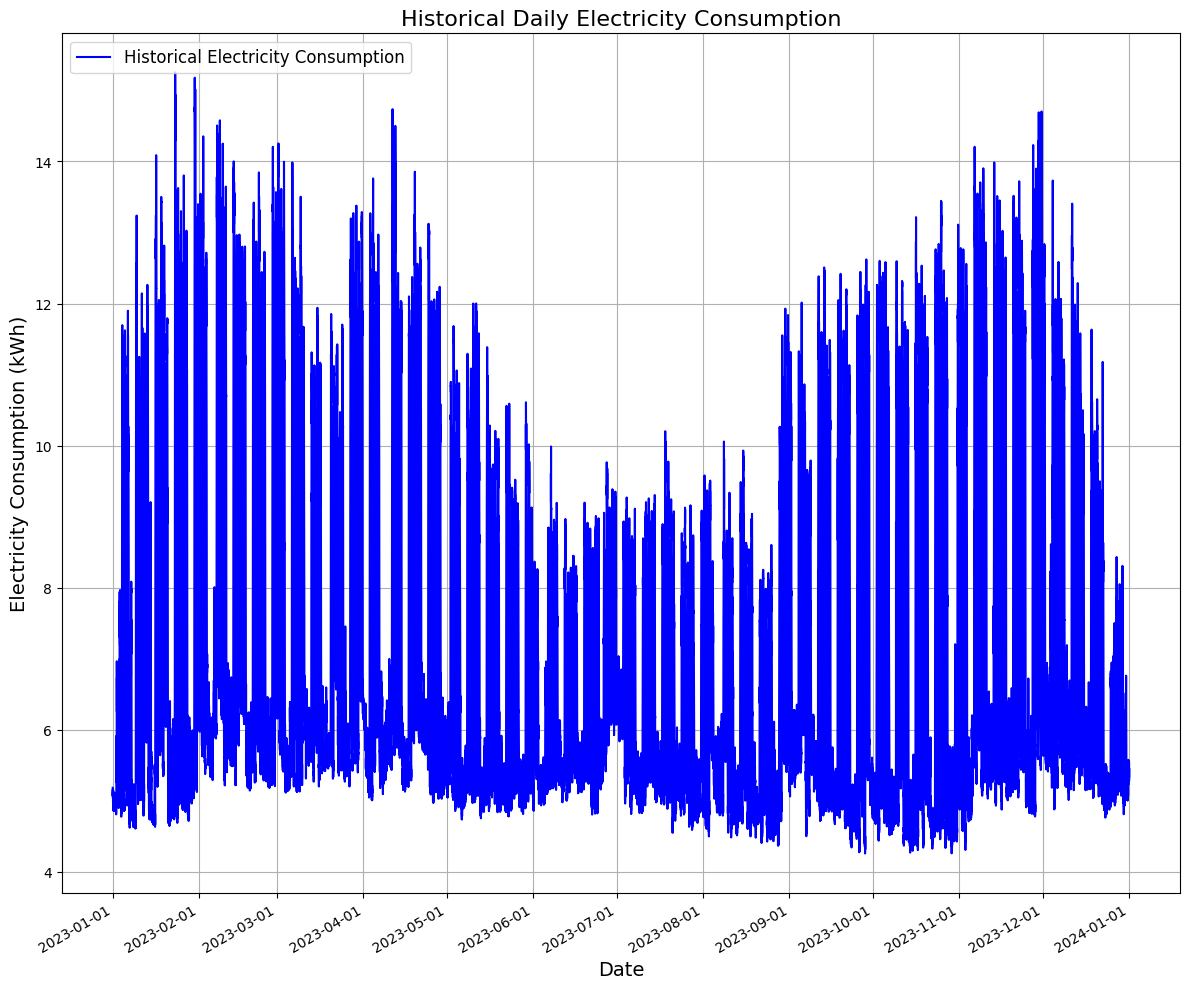

In [27]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Resample the data to daily frequency, aggregating with the mean for each day
daily_consumption = df2023['Elec_Consump']

plt.figure(figsize=(12, 10))

# Plot the historical daily consumption
plt.plot(daily_consumption.index, daily_consumption, label='Historical Electricity Consumption', color='blue')

plt.xlabel('Date', fontsize=14)
plt.ylabel('Electricity Consumption (kWh)', fontsize=14)
plt.title('Historical Daily Electricity Consumption', fontsize=16)
plt.legend(fontsize=12, loc='upper left')

# Set major ticks format
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())

plt.grid(True)

plt.gcf().autofmt_xdate()  # Format the x-axis labels for better readability

plt.tight_layout()
plt.show()

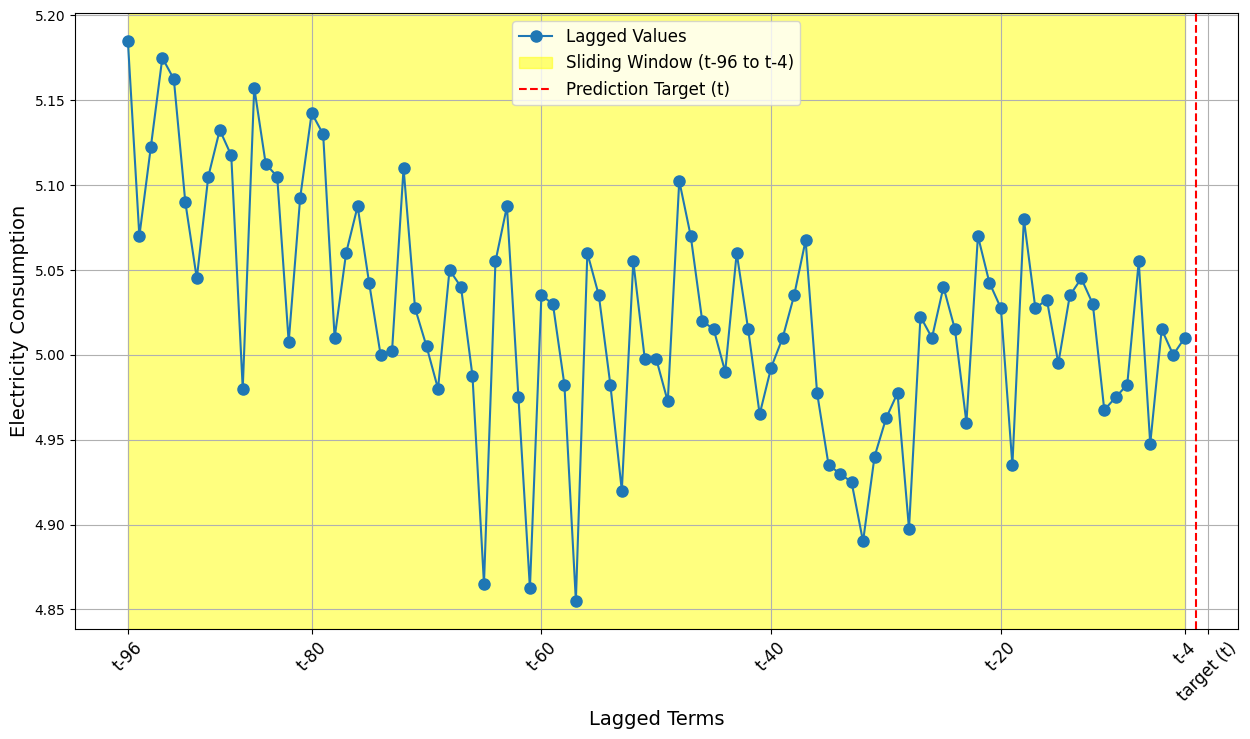

In [28]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np


# Define the range of lags and the target point for prediction
start_lag = 4
end_lag = 96
target_point = 97  # point to be predicted, adjusted for larger data set

# Generate the DataFrame with lagged features
lags = list(range(start_lag, end_lag + 1))
lag_data = {f't-{lag}': df2023['Elec_Consump'].shift(lag) for lag in reversed(lags)}
lagged_df = pd.DataFrame(lag_data)

# Drop the NaN values which are the result of the lagging
lagged_df = lagged_df.dropna().reset_index(drop=True)

# Ensure we correctly fetch the target row based on your larger dataset
target_row = lagged_df.iloc[min(target_point - max(lags) - 1, len(lagged_df) - 1)]

# Plotting the lagged values with the sliding window and prediction point
plt.figure(figsize=(15, 8))  # Increased figure size for better readability
plt.plot(lagged_df.columns, target_row, marker='o', linestyle='-', label='Lagged Values', markersize=8)
plt.axvspan(f't-{end_lag}', f't-{start_lag}', color='yellow', alpha=0.5, label='Sliding Window (t-96 to t-4)')
plt.axvline(f't-{target_point}', color='red', linestyle='--', label='Prediction Target (t)')
# Customize x-axis add target point
x_labels = [f't-{lag}' for lag in range(end_lag, start_lag - 1, -1) if lag % 20 == 0 or lag in [start_lag, end_lag]]
x_labels.append(f'target (t)')
plt.xticks(x_labels, rotation=45, fontsize=12)

plt.xlabel('Lagged Terms', fontsize=14)
plt.ylabel('Electricity Consumption', fontsize=14)
plt.legend( fontsize=12)
plt.grid(True)
plt.show()


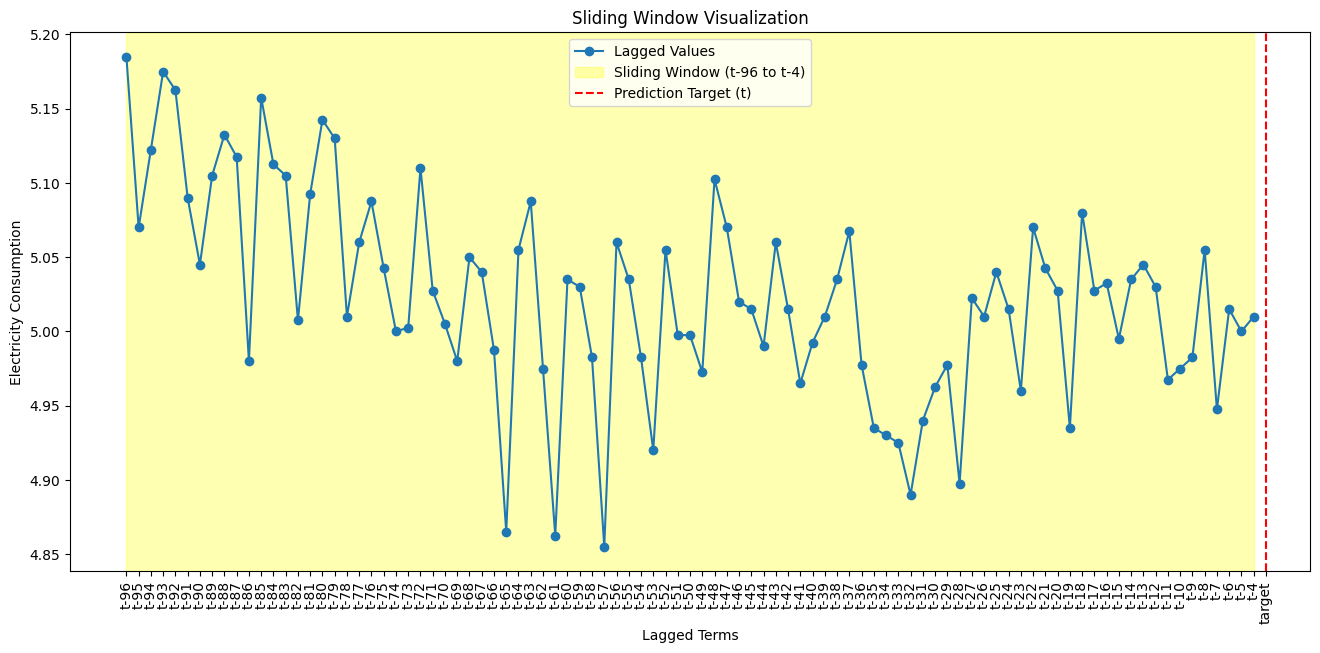

In [29]:
start_lag = 4
end_lag = 96
target_point = 97

# Generate the DataFrame with lagged features
lags = list(range(start_lag, end_lag + 1))
lag_data = {
    f't-{lag}': df2023['Elec_Consump'].shift(lag)
    for lag in reversed(lags)
}
lagged_df = pd.DataFrame(lag_data)

# Drop the NaN values which are the result of the lagging
lagged_df = lagged_df.dropna().reset_index(drop=True)

# Get the target row for the prediction point (t-97)
target_row = lagged_df.iloc[target_point - max(lags) - 1]

# Plotting the lagged values with the sliding window and prediction point
plt.figure(figsize=(16, 7))
plt.plot(lagged_df.columns, target_row, marker='o', linestyle='-', label='Lagged Values')
plt.axvspan(f't-{end_lag}', f't-{start_lag}', color='yellow', alpha=0.3, label='Sliding Window (t-96 to t-4)')
plt.axvline(f'target', color='red', linestyle='--', label='Prediction Target (t)')
plt.xlabel('Lagged Terms')
plt.ylabel('Electricity Consumption')
plt.title('Sliding Window Visualization')
plt.legend()
plt.xticks(rotation=90)
plt.show()

In [30]:
def is_working_month(row):
    if 1 <= row['month'] <= 5:
        return 1 if row['day'] >= 15 else 0
    elif 9 <= row['month'] <= 12:
        return 1 if row['day'] <= 15 else 0
    elif row['month'] == 9:
        return 1 if row['day'] >= 15 else 0
    return 0

In [31]:
df2023['is_working_month'] = df2023.apply(is_working_month, axis=1)

In [32]:
df2023

,Elec_Consump,Light_Lux,Temperature,Humidity,hour,is_working_hour,day,month,weekday,is_weekend,is_working_month
Timestamp,,,,,,,,,,,
2023-01-01 00:00:00,5.1850,0.0,7.770116,77.383438,0,0,1,1,6,1,0
2023-01-01 00:15:00,5.0700,0.0,7.799185,75.507317,0,0,1,1,6,1,0
2023-01-01 00:30:00,5.1225,0.0,7.778664,74.396828,0,0,1,1,6,1,0
2023-01-01 00:45:00,5.1750,0.0,7.591584,74.444031,0,0,1,1,6,1,0
2023-01-01 01:00:00,5.1625,0.0,7.158571,76.209259,1,0,1,1,6,1,0
...,...,...,...,...,...,...,...,...,...,...,...
2023-12-31 22:45:00,5.3775,0.0,7.002996,80.419502,22,0,31,12,6,1,0
2023-12-31 23:00:00,5.2825,0.0,6.936085,80.672668,23,0,31,12,6,1,0
2023-12-31 23:15:00,5.3900,0.0,6.945076,81.107307,23,0,31,12,6,1,0


In [33]:
X_2023 = df2023.drop('Elec_Consump', axis=1)
y_2023 = df2023['Elec_Consump']

Text(0.5, 1.0, 'Global Feature Importance - RandomForestRegressor')

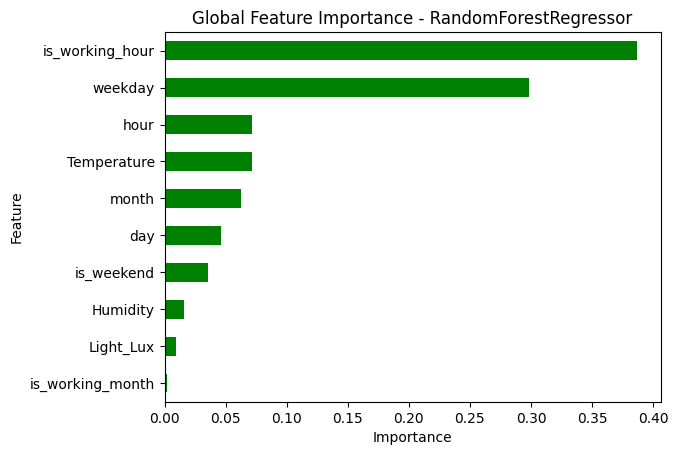

In [34]:
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_estimators=100, random_state=1)
rf.fit(X_2023, y_2023)

global_importances = pd.Series(rf.feature_importances_, index=X_2023.columns)
global_importances.sort_values(ascending=True, inplace=True)
global_importances.plot.barh(color='green')
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("Global Feature Importance - RandomForestRegressor")

In [35]:
df2023 = df2023.drop(['is_working_month','Humidity','Light_Lux','hour','day','month','Temperature','is_working_hour'], axis=1)
df2023

,Elec_Consump,weekday,is_weekend
Timestamp,,,
2023-01-01 00:00:00,5.1850,6,1
2023-01-01 00:15:00,5.0700,6,1
2023-01-01 00:30:00,5.1225,6,1
2023-01-01 00:45:00,5.1750,6,1
2023-01-01 01:00:00,5.1625,6,1
...,...,...,...
2023-12-31 22:45:00,5.3775,6,1
2023-12-31 23:00:00,5.2825,6,1
2023-12-31 23:15:00,5.3900,6,1


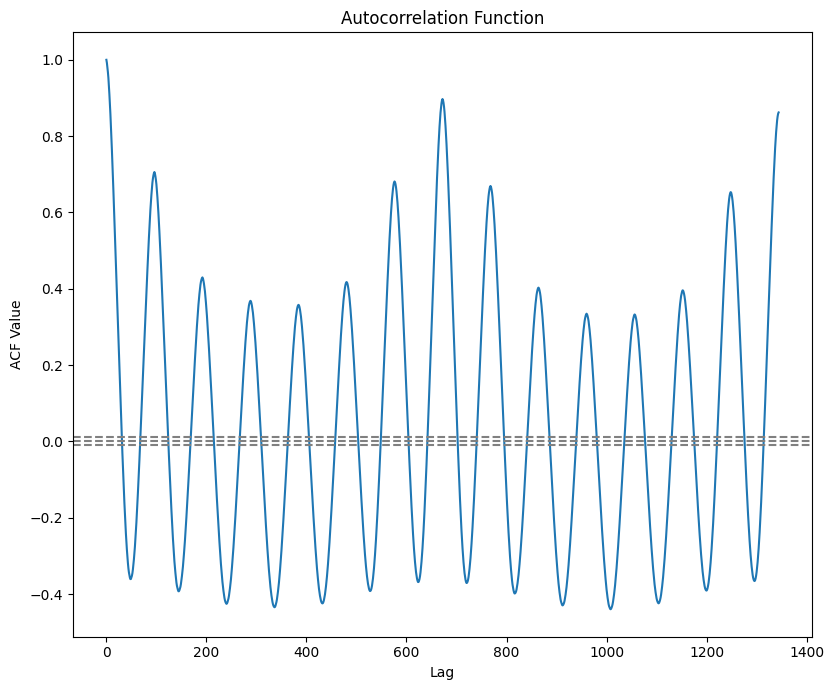

In [36]:
df_acf = df2023['Elec_Consump']
lag_acf = acf(df_acf, nlags=1344)
confint = 1.96/np.sqrt(len(df_acf))
plt.figure(figsize=(16, 7))
plt.subplot(121)
plt.plot(lag_acf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-confint, linestyle='--', color='gray')  # Lower confidence interval
plt.axhline(y=confint, linestyle='--', color='gray')   # Upper confidence interval
plt.title('Autocorrelation Function')
plt.xlabel('Lag')
plt.ylabel('ACF Value')

plt.tight_layout()
plt.show()

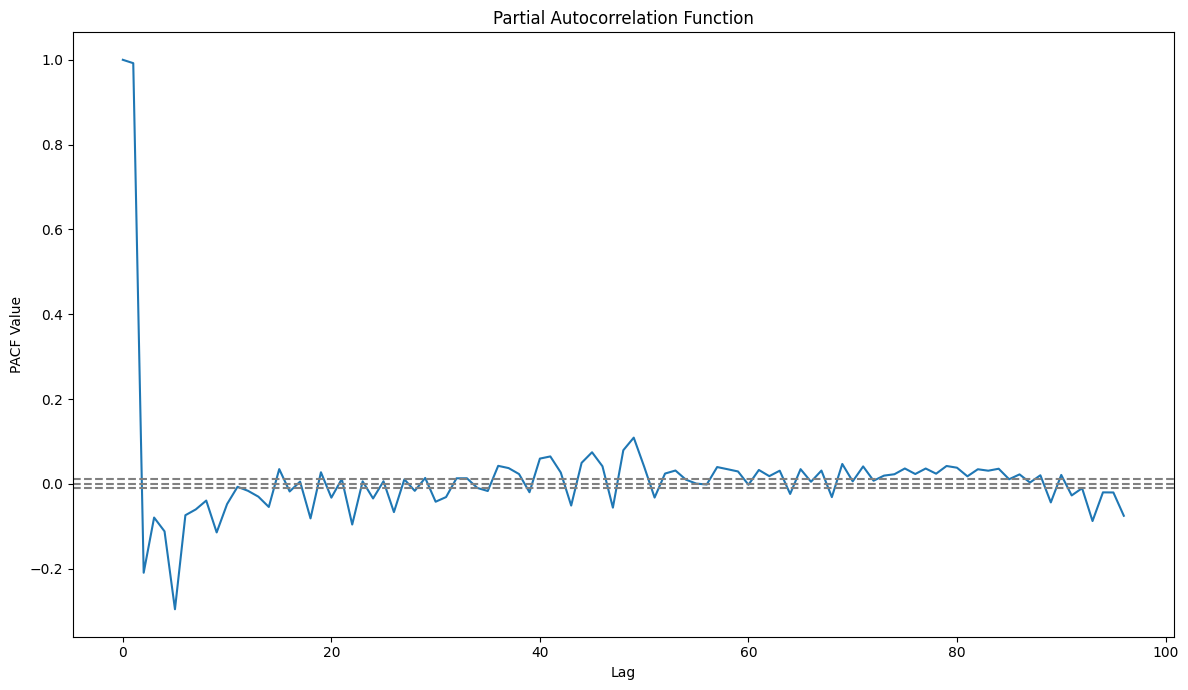

In [37]:
df_acf = df2023['Elec_Consump']

lag_pacf = pacf(df_acf, nlags=96, method='ols')

# Define confidence interval
confint = 1.96/np.sqrt(len(df_acf))
# Plot PACF on a separate plot
plt.figure(figsize=(12, 7))
plt.plot(lag_pacf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-confint, linestyle='--', color='gray')  # Lower confidence interval
plt.axhline(y=confint, linestyle='--', color='gray')   # Upper confidence interval
plt.title('Partial Autocorrelation Function')
plt.xlabel('Lag')
plt.ylabel('PACF Value') 
plt.tight_layout()
plt.show()

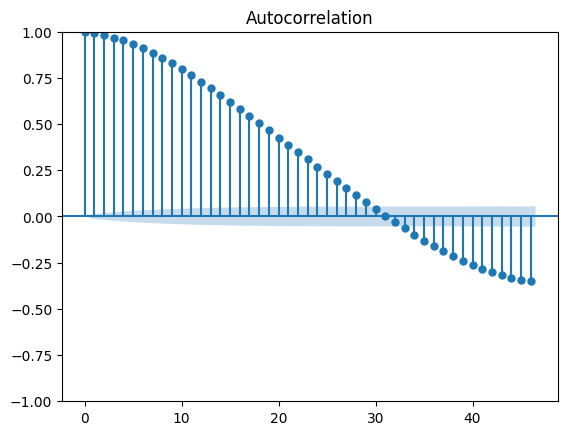

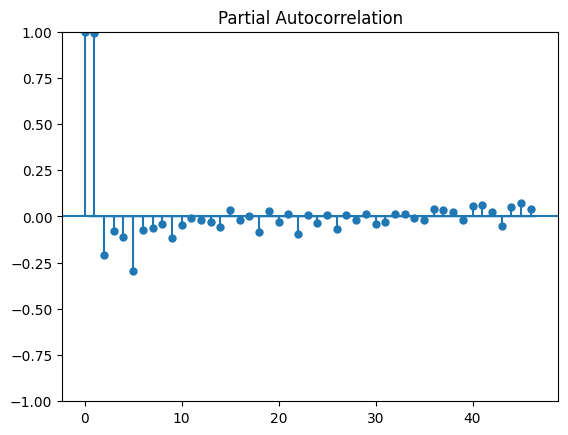

In [38]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(df2023['Elec_Consump'])
plot_pacf(df2023['Elec_Consump'])
plt.show()

In [39]:
def series_to_supervised(data, n_in, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    dff = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence for specific lags in n_in
    for i in n_in:
        cols.append(dff.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(dff.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [40]:
# import minimax scaler
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))

In [41]:
def mean_bias_error(y_true, y_pred):
    return np.mean(y_pred - y_true)

In [42]:
transformed_df_hour = series_to_supervised(df2023, n_in=[4,5,6,7,96,672], n_out=1)
columns_to_keep = [col for col in transformed_df_hour.columns if 'var1(t-' in col] + ['var2(t)', 'var3(t)']
X_hour = transformed_df_hour[columns_to_keep]
y_hour = transformed_df_hour['var1(t)']
X_train_hour, X_test_hour, y_train_hour, y_test_hour = train_test_split(X_hour, y_hour, test_size=0.5, shuffle=False)
X_train_scaled_hour = scaler.fit_transform(X_train_hour)
X_test_scaled_hour = scaler.transform(X_test_hour)

In [43]:
param_dist = {
    'n_estimators': [50, 100, 200],
    'max_depth': [10, 15],
    'min_samples_split': [5, 10],
    'min_samples_leaf': [1, 2, 4]
}
model = RandomForestRegressor()
# Define the time series cross-validator
tscv = TimeSeriesSplit(n_splits=5)

random_search = RandomizedSearchCV(estimator=model, param_distributions=param_dist,cv=tscv, scoring='neg_mean_squared_error', n_jobs=-1,verbose=3,random_state=1)
random_search.fit(X_train_scaled_hour, y_train_hour)
results = random_search.cv_results_

for i in range(len(results['params'])):
    params = results['params'][i]
    mean_test_score = results['mean_test_score'][i]
    rmse = np.sqrt(-mean_test_score)
    print(f"Iteration {i+1}: Params: {params}, RMSE: {rmse}")
    
best_rf_hour = random_search.best_estimator_
print(f"Best parameters: {best_rf_hour}")

best_score = np.sqrt(-random_search.best_score_)
print(f"Best RMSE: {best_score}")

predictions_rf_hour = best_rf_hour.predict(X_test_scaled_hour)
rf_rmse_hour = sqrt(mean_squared_error(y_test_hour, predictions_rf_hour))
print(f"Best RMSE on Test Set: {rf_rmse_hour}")

rf_mbe_hour = mean_bias_error(y_test_hour, predictions_rf_hour)
print(f"Mean Bias Error on Test Set: {rf_mbe_hour}")

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Iteration 1: Params: {'n_estimators': 50, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_depth': 15}, RMSE: 0.5753841015719833
Iteration 2: Params: {'n_estimators': 100, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_depth': 15}, RMSE: 0.5747090382310365
Iteration 3: Params: {'n_estimators': 100, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_depth': 15}, RMSE: 0.5798809536625062
Iteration 4: Params: {'n_estimators': 50, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_depth': 10}, RMSE: 0.5783044034407024
Iteration 5: Params: {'n_estimators': 100, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_depth': 15}, RMSE: 0.5787558749895517
Iteration 6: Params: {'n_estimators': 200, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_depth': 10}, RMSE: 0.5725256308328718
Iteration 7: Params: {'n_estimators': 50, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_depth': 15}, RMSE: 0.5757163404540413
Iterat

In [45]:
svm_model = make_pipeline(StandardScaler(), SVR(kernel='linear'))

# Time series cross-validator
tscv = TimeSeriesSplit(n_splits=25)

# Parameter grid
param_grid = {
    'svr__C': [0.1, 1, 10],
    'svr__epsilon': [0.01, 0.1, 1]
}

# Instantiate GridSearchCV with verbose=3 for detailed output
grid_search = GridSearchCV(svm_model, param_grid, cv=tscv, scoring='neg_mean_squared_error', n_jobs=-1, verbose=3)

# Fit GridSearchCV
grid_search.fit(X_train_scaled_hour, y_train_hour)
results = grid_search.cv_results_
for i in range(len(results['params'])):
    params = results['params'][i]
    mean_test_score = results['mean_test_score'][i]
    rmse = np.sqrt(-mean_test_score)
    print(f"Iteration {i+1}: Params: {params}, RMSE: {rmse}")
# Best parameters
best_svm_hour = grid_search.best_estimator_
print(f"Best parameters: {best_svm_hour}")

best_score = np.sqrt(-grid_search.best_score_)
print(f"Best RMSE: {best_score}")

predictions_svm_hour = best_svm_hour.predict(X_test_scaled_hour)
svm_rmse_hour = sqrt(mean_squared_error(y_test_hour, predictions_svm_hour))
print(f"Best RMSE on Test Set: {svm_rmse_hour}")
svm_mbe_hour = mean_bias_error(y_test_hour, predictions_svm_hour)
print(f"Mean Bias Error on Test Set: {svm_mbe_hour}")

Fitting 25 folds for each of 9 candidates, totalling 225 fits
Iteration 1: Params: {'svr__C': 0.1, 'svr__epsilon': 0.01}, RMSE: 0.5696962684980235
Iteration 2: Params: {'svr__C': 0.1, 'svr__epsilon': 0.1}, RMSE: 0.5688625827048249
Iteration 3: Params: {'svr__C': 0.1, 'svr__epsilon': 1}, RMSE: 0.6369428749793707
Iteration 4: Params: {'svr__C': 1, 'svr__epsilon': 0.01}, RMSE: 0.5644867704181521
Iteration 5: Params: {'svr__C': 1, 'svr__epsilon': 0.1}, RMSE: 0.5636370871463025
Iteration 6: Params: {'svr__C': 1, 'svr__epsilon': 1}, RMSE: 0.6216486074303009
Iteration 7: Params: {'svr__C': 10, 'svr__epsilon': 0.01}, RMSE: 0.5639212411207468
Iteration 8: Params: {'svr__C': 10, 'svr__epsilon': 0.1}, RMSE: 0.5630883315588773
Iteration 9: Params: {'svr__C': 10, 'svr__epsilon': 1}, RMSE: 0.6207421160089251
Best parameters: Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svr', SVR(C=10, kernel='linear'))])
Best RMSE: 0.5630883315588773
Best RMSE on Test Set: 0.57579542951621

In [46]:
# parameters for the xgb model
param_dist = {
    'n_estimators': [50, 100, 150],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 0.9, 1],
    'colsample_bytree': [0.8, 0.9, 1],
}

# time series cross-validator
tscv = TimeSeriesSplit(n_splits=5)

xgb_model = XGBRegressor(objective='reg:squarederror')

# random search
random_search = RandomizedSearchCV(estimator=xgb_model, param_distributions=param_dist, n_iter=10, cv=tscv, scoring='neg_mean_squared_error', n_jobs=-1, verbose=2, random_state=1)
random_search.fit(X_train_scaled_hour, y_train_hour)
results = random_search.cv_results_

print("All iterations:")
for i in range(len(results['params'])):
    params = results['params'][i] 
    mean_test_score = results['mean_test_score'][i]  
    rmse = np.sqrt(-mean_test_score) 
    print(f"Iteration {i+1}: Params: {params}, RMSE: {rmse}")

best_XGB_hour = random_search.best_params_
print("Best parameters found: ", best_XGB_hour)

best_score = np.sqrt(-random_search.best_score_)
print(f"Best RMSE: {best_score}")

predictions_xgb_hour = random_search.best_estimator_.predict(X_test_scaled_hour)
xgb_rmse_hour = sqrt(mean_squared_error(y_test_hour, predictions_xgb_hour))
print(f"Test RMSE with XGBoost using optimized parameters: {xgb_rmse_hour}")

xgb_mbe_hour = mean_bias_error(y_test_hour, predictions_xgb_hour)
print(f"Mean Bias Error on Test Set: {xgb_mbe_hour}")

Fitting 5 folds for each of 10 candidates, totalling 50 fits
All iterations:
Iteration 1: Params: {'subsample': 0.9, 'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.1, 'colsample_bytree': 0.8}, RMSE: 0.5608920117842784
Iteration 2: Params: {'subsample': 1, 'n_estimators': 150, 'max_depth': 7, 'learning_rate': 0.1, 'colsample_bytree': 1}, RMSE: 0.5907785384401774
Iteration 3: Params: {'subsample': 0.9, 'n_estimators': 150, 'max_depth': 5, 'learning_rate': 0.05, 'colsample_bytree': 1}, RMSE: 0.5611488790967812
Iteration 4: Params: {'subsample': 1, 'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.05, 'colsample_bytree': 0.9}, RMSE: 0.5554241183412179
Iteration 5: Params: {'subsample': 1, 'n_estimators': 150, 'max_depth': 3, 'learning_rate': 0.01, 'colsample_bytree': 0.9}, RMSE: 0.7493162169115235
Iteration 6: Params: {'subsample': 0.9, 'n_estimators': 50, 'max_depth': 3, 'learning_rate': 0.1, 'colsample_bytree': 1}, RMSE: 0.5580655676210341
Iteration 7: Params: {'subsample'

In [47]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('mlp', MLPRegressor(max_iter=1000))
])

# paramater grid
param_distributions = {
    'mlp__hidden_layer_sizes': [(50,), (100,)],
    'mlp__activation': ['tanh', 'relu'],
    'mlp__alpha': np.logspace(-4, -2, 3) 
}
tscv = TimeSeriesSplit(n_splits=5)
# set up the randomized search
random_search = RandomizedSearchCV(pipeline, param_distributions, n_iter=5, 
                                   scoring='neg_mean_squared_error', cv=tscv, verbose=2, random_state=1)

random_search.fit(X_train_hour, y_train_hour)
results = random_search.cv_results_

print("All iterations:")
for i in range(len(results['params'])):
    params = results['params'][i] 
    mean_test_score = results['mean_test_score'][i]  
    rmse = np.sqrt(-mean_test_score) 
    print(f"Iteration {i+1}: Params: {params}, RMSE: {rmse}")
    
best_mlp_model = random_search.best_params_
print("Best parameters:", best_mlp_model)
best_score = np.sqrt(-random_search.best_score_)
print(f"Best RMSE: {best_score}")
predictions_mlp_hour = random_search.best_estimator_.predict(X_test_hour)
mlp_rmse_hour = sqrt(mean_squared_error(y_test_hour, predictions_mlp_hour))
print(f"Test RMSE with optimized MLP: {mlp_rmse_hour}")


mlp_mbe_hour = mean_bias_error(y_test_hour, predictions_mlp_hour)
print(f"Mean Bias Error on Test Set: {mlp_mbe_hour}")

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV] END mlp__activation=tanh, mlp__alpha=0.001, mlp__hidden_layer_sizes=(50,); total time=   2.1s
[CV] END mlp__activation=tanh, mlp__alpha=0.001, mlp__hidden_layer_sizes=(50,); total time=   5.2s
[CV] END mlp__activation=tanh, mlp__alpha=0.001, mlp__hidden_layer_sizes=(50,); total time=   4.2s
[CV] END mlp__activation=tanh, mlp__alpha=0.001, mlp__hidden_layer_sizes=(50,); total time=   5.0s
[CV] END mlp__activation=tanh, mlp__alpha=0.001, mlp__hidden_layer_sizes=(50,); total time=   6.6s
[CV] END mlp__activation=tanh, mlp__alpha=0.001, mlp__hidden_layer_sizes=(100,); total time=   2.7s
[CV] END mlp__activation=tanh, mlp__alpha=0.001, mlp__hidden_layer_sizes=(100,); total time=   3.9s
[CV] END mlp__activation=tanh, mlp__alpha=0.001, mlp__hidden_layer_sizes=(100,); total time=   5.1s
[CV] END mlp__activation=tanh, mlp__alpha=0.001, mlp__hidden_layer_sizes=(100,); total time=   7.6s
[CV] END mlp__activation=tanh, mlp__alpha=0.0

In [48]:
# Define a pipeline that standardizes the data then applies Ridge regression
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('ridge', Ridge())
])

param_grid = {
    'ridge__alpha': np.logspace(-4, 4, 10)
}

tscv = TimeSeriesSplit(n_splits=5)

grid_search = GridSearchCV(pipeline, param_grid, cv=tscv, scoring='neg_mean_squared_error', n_jobs=-1, verbose=2)
grid_search.fit(X_train_hour, y_train_hour)

results = grid_search.cv_results_
print("All iterations:")
for i in range(len(results['params'])):
    params = results['params'][i]
    mean_test_score = results['mean_test_score'][i]
    rmse = np.sqrt(-mean_test_score)
    print(f"Iteration {i+1}: Params: {params}, RMSE: {rmse}")

print("Best parameters:", grid_search.best_params_)
predictions_ridge_hour = grid_search.best_estimator_.predict(X_test_hour)
ridge_rmse_hour = sqrt(mean_squared_error(y_test_hour, predictions_ridge_hour))
print(f"Test RMSE with optimized Ridge regression: {ridge_rmse_hour}")

ridge_mbe_hour = mean_bias_error(y_test_hour, predictions_ridge_hour)
print(f"Mean Bias Error on Test Set: {ridge_mbe_hour}")

Fitting 5 folds for each of 10 candidates, totalling 50 fits
All iterations:
Iteration 1: Params: {'ridge__alpha': 0.0001}, RMSE: 0.5501098162889633
Iteration 2: Params: {'ridge__alpha': 0.000774263682681127}, RMSE: 0.5501098114602087
Iteration 3: Params: {'ridge__alpha': 0.005994842503189409}, RMSE: 0.5501097754359194
Iteration 4: Params: {'ridge__alpha': 0.046415888336127774}, RMSE: 0.5501095777390835
Iteration 5: Params: {'ridge__alpha': 0.3593813663804626}, RMSE: 0.5501127028084396
Iteration 6: Params: {'ridge__alpha': 2.782559402207126}, RMSE: 0.5503448566281043
Iteration 7: Params: {'ridge__alpha': 21.54434690031882}, RMSE: 0.5561332769829405
Iteration 8: Params: {'ridge__alpha': 166.81005372000558}, RMSE: 0.6052452103997902
Iteration 9: Params: {'ridge__alpha': 1291.5496650148827}, RMSE: 0.6952988871161854
Iteration 10: Params: {'ridge__alpha': 10000.0}, RMSE: 0.9429022853385022
Best parameters: {'ridge__alpha': 0.046415888336127774}
Test RMSE with optimized Ridge regression: 0.

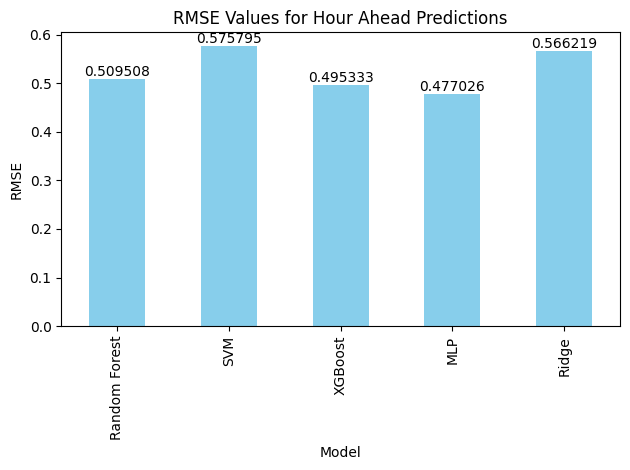

,RMSE
Random Forest,0.509508
SVM,0.575795
XGBoost,0.495333
MLP,0.477026
Ridge,0.566219


In [49]:
# create a dataframe with the RMSE and MBE values for hour and plot in bar chart
mbe_values_hour = [rf_mbe_hour, svm_mbe_hour, xgb_mbe_hour, mlp_mbe_hour, ridge_mbe_hour]
rmse_values_hour = [rf_rmse_hour, svm_rmse_hour, xgb_rmse_hour, mlp_rmse_hour, ridge_rmse_hour]
models = ['Random Forest', 'SVM', 'XGBoost', 'MLP', 'Ridge']
mbe_df_hour = pd.DataFrame(mbe_values_hour, index=models, columns=['MBE'])
rmse_df_hour = pd.DataFrame(rmse_values_hour, index=models, columns=['RMSE'])
ax = rmse_df_hour.plot(kind='bar', color='skyblue', legend=False)
plt.title('RMSE Values for Hour Ahead Predictions')
plt.ylabel('RMSE')
plt.xlabel('Model')
for container in ax.containers:
    ax.bar_label(container)
plt.tight_layout()
plt.show()
rmse_df_hour

In [50]:
transformed_df_day= series_to_supervised(df2023, n_in=[96,192,288,384,480,576,672,1344],n_out=1)
columns_to_keep = [col for col in transformed_df_day.columns if 'var1(t-' in col] + ['var2(t)', 'var3(t)']
X_day= transformed_df_day[columns_to_keep]
y_day = transformed_df_day['var1(t)']
X_train_day, X_test_day, y_train_day, y_test_day = train_test_split(X_day, y_day, test_size=0.5, shuffle=False)
X_train_scaled_day = scaler.fit_transform(X_train_day)
X_test_scaled_day = scaler.transform(X_test_day)

In [51]:
param_dist = {
    'n_estimators': [100, 200],
    'max_depth': [10, 15],
    'min_samples_split': [5, 10],
    'min_samples_leaf': [1, 2, 4]
}
model = RandomForestRegressor()
tscv = TimeSeriesSplit(n_splits=5)

random_search = RandomizedSearchCV(estimator=model, param_distributions=param_dist, cv=tscv, scoring='neg_mean_squared_error', n_jobs=-1,verbose=3,random_state=1)

random_search.fit(X_train_scaled_day, y_train_day)
results = random_search.cv_results_

for i in range(len(results['params'])):
    params = results['params'][i]
    mean_test_score = results['mean_test_score'][i]
    rmse = np.sqrt(-mean_test_score)
    print(f"Iteration {i+1}: Params: {params}, RMSE: {rmse}")

best_rf_day = random_search.best_estimator_
print(f"Best parameters: {best_rf_day}")

best_score = np.sqrt(-random_search.best_score_)
print(f"Best RMSE: {best_score}")

predictions_rf_day = best_rf_day.predict(X_test_scaled_day)
rf_rmse_day = sqrt(mean_squared_error(y_test_day, predictions_rf_day))
print(f"Best RMSE on Test Set: {rf_rmse_day}")

rf_mbe_day = mean_bias_error(y_test_day, predictions_rf_day)
print(f"Mean Bias Error on Test Set: {rf_mbe_day}")

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Iteration 1: Params: {'n_estimators': 200, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_depth': 15}, RMSE: 0.9262643197863757
Iteration 2: Params: {'n_estimators': 100, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_depth': 15}, RMSE: 0.9311416690280255
Iteration 3: Params: {'n_estimators': 200, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_depth': 10}, RMSE: 0.9286139525211683
Iteration 4: Params: {'n_estimators': 100, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_depth': 15}, RMSE: 0.9277106389331664
Iteration 5: Params: {'n_estimators': 100, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_depth': 15}, RMSE: 0.9358516816908419
Iteration 6: Params: {'n_estimators': 200, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_depth': 15}, RMSE: 0.9249027054018132
Iteration 7: Params: {'n_estimators': 100, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_depth': 10}, RMSE: 0.9268672202604125
Iter

In [52]:
svm_model = make_pipeline(StandardScaler(), SVR(kernel='linear'))

# Time series cross-validator
tscv = TimeSeriesSplit(n_splits=5)

# Parameter grid
param_grid = {
    'svr__C': [0.1, 1, 10],
    'svr__epsilon': [0.01, 0.1, 1]
}

# Instantiate GridSearchCV with verbose=3 for detailed output
grid_search = GridSearchCV(svm_model, param_grid, cv=tscv, scoring='neg_mean_squared_error', n_jobs=-1, verbose=3)

# Fit GridSearchCV
grid_search.fit(X_train_scaled_day, y_train_day)
results = grid_search.cv_results_
for i in range(len(results['params'])):
    params = results['params'][i]
    mean_test_score = results['mean_test_score'][i]
    rmse = np.sqrt(-mean_test_score)
    print(f"Iteration {i+1}: Params: {params}, RMSE: {rmse}")
# Best parameters
best_svm_day = grid_search.best_estimator_
print(f"Best parameters: {best_svm_day}")

best_score = np.sqrt(-grid_search.best_score_)
print(f"Best RMSE: {best_score}")

predictions_svm_day = best_svm_day.predict(X_test_scaled_day)
svm_rmse_day = sqrt(mean_squared_error(y_test_day, predictions_svm_day))
print(f"Best RMSE on Test Set: {svm_rmse_day}")

svm_mbe_day = mean_bias_error(y_test_day, predictions_svm_day)
print(f"Mean Bias Error on Test Set: {svm_mbe_day}")

Fitting 5 folds for each of 9 candidates, totalling 45 fits
Iteration 1: Params: {'svr__C': 0.1, 'svr__epsilon': 0.01}, RMSE: 1.0088438467430239
Iteration 2: Params: {'svr__C': 0.1, 'svr__epsilon': 0.1}, RMSE: 1.0084563568874463
Iteration 3: Params: {'svr__C': 0.1, 'svr__epsilon': 1}, RMSE: 1.0032380804710248
Iteration 4: Params: {'svr__C': 1, 'svr__epsilon': 0.01}, RMSE: 1.013224548586448
Iteration 5: Params: {'svr__C': 1, 'svr__epsilon': 0.1}, RMSE: 1.0120227190744262
Iteration 6: Params: {'svr__C': 1, 'svr__epsilon': 1}, RMSE: 1.0105071776676104
Iteration 7: Params: {'svr__C': 10, 'svr__epsilon': 0.01}, RMSE: 1.013480929533872
Iteration 8: Params: {'svr__C': 10, 'svr__epsilon': 0.1}, RMSE: 1.0120933071527027
Iteration 9: Params: {'svr__C': 10, 'svr__epsilon': 1}, RMSE: 1.011287223697734
Best parameters: Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svr', SVR(C=0.1, epsilon=1, kernel='linear'))])
Best RMSE: 1.0032380804710248
Best RMSE on Test Set: 0.8288410

In [53]:
# parameters for the MLP model
param_dist = {
    'n_estimators': [50, 100, 150],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 0.9, 1],
    'colsample_bytree': [0.8, 0.9, 1]
}

# time series cross-validator
tscv = TimeSeriesSplit(n_splits=5)

xgb_model = XGBRegressor(objective='reg:squarederror')

# random search
random_search = RandomizedSearchCV(estimator=xgb_model, param_distributions=param_dist, n_iter=10, cv=tscv, scoring='neg_mean_squared_error', n_jobs=-1, verbose=2, random_state=1)
random_search.fit(X_train_scaled_day, y_train_day)
results = random_search.cv_results_

print("All iterations:")
for i in range(len(results['params'])):
    params = results['params'][i] 
    mean_test_score = results['mean_test_score'][i]  
    rmse = np.sqrt(-mean_test_score) 
    print(f"Iteration {i+1}: Params: {params}, RMSE: {rmse}")

best_XGB_day = random_search.best_estimator_
print("Best parameters found: ", best_XGB_day)

best_score = np.sqrt(-random_search.best_score_)
print(f"Best RMSE: {best_score}")

predictions_xgb_day = best_XGB_day.predict(X_test_scaled_day)
xgb_rmse_day = sqrt(mean_squared_error(y_test_day, predictions_xgb_day))
print(f"Test RMSE with XGBoost using optimized parameters: {xgb_rmse_day}")

xgb_mbe_day = mean_bias_error(y_test_day, predictions_xgb_day)
print(f"Mean Bias Error on Test Set: {xgb_mbe_day}")

Fitting 5 folds for each of 10 candidates, totalling 50 fits
All iterations:
Iteration 1: Params: {'subsample': 0.9, 'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.1, 'colsample_bytree': 0.8}, RMSE: 0.9086099101977286
Iteration 2: Params: {'subsample': 1, 'n_estimators': 150, 'max_depth': 7, 'learning_rate': 0.1, 'colsample_bytree': 1}, RMSE: 0.9321730759298491
Iteration 3: Params: {'subsample': 0.9, 'n_estimators': 150, 'max_depth': 5, 'learning_rate': 0.05, 'colsample_bytree': 1}, RMSE: 0.9243267046276019
Iteration 4: Params: {'subsample': 1, 'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.05, 'colsample_bytree': 0.9}, RMSE: 0.8999038521971996
Iteration 5: Params: {'subsample': 1, 'n_estimators': 150, 'max_depth': 3, 'learning_rate': 0.01, 'colsample_bytree': 0.9}, RMSE: 1.0006752968542403
Iteration 6: Params: {'subsample': 0.9, 'n_estimators': 50, 'max_depth': 3, 'learning_rate': 0.1, 'colsample_bytree': 1}, RMSE: 0.944974589925843
Iteration 7: Params: {'subsample':

In [54]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('mlp', MLPRegressor(max_iter=1000))
])

# paramater grid
param_distributions = {
    'mlp__hidden_layer_sizes': [(50,), (100,)],
    'mlp__activation': ['tanh', 'relu'],
    'mlp__alpha': np.logspace(-4, -2, 3) 
}

# set up the randomized search
random_search = RandomizedSearchCV(pipeline, param_distributions, n_iter=5, 
                                   scoring='neg_mean_squared_error', cv=3, verbose=2, random_state=1)

random_search.fit(X_train_day, y_train_day)
results = random_search.cv_results_

print("All iterations:")
for i in range(len(results['params'])):
    params = results['params'][i] 
    mean_test_score = results['mean_test_score'][i]  
    rmse = np.sqrt(-mean_test_score) 
    print(f"Iteration {i+1}: Params: {params}, RMSE: {rmse}")
    
best_mlp_day = random_search.best_estimator_
print("Best parameters:", best_mlp_day)
best_score = np.sqrt(-random_search.best_score_)
print(f"Best RMSE: {best_score}")
predictions_mlp_day = best_mlp_day.predict(X_test_day)
mlp_rmse_day = sqrt(mean_squared_error(y_test_day, predictions_mlp_day))
print(f"Test RMSE with optimized MLP: {mlp_rmse_day}")

mlp_mbe_day = mean_bias_error(y_test_day, predictions_mlp_day)
print(f"Mean Bias Error on Test Set: {mlp_mbe_day}")

Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV] END mlp__activation=tanh, mlp__alpha=0.001, mlp__hidden_layer_sizes=(50,); total time=   8.0s
[CV] END mlp__activation=tanh, mlp__alpha=0.001, mlp__hidden_layer_sizes=(50,); total time=   6.5s
[CV] END mlp__activation=tanh, mlp__alpha=0.001, mlp__hidden_layer_sizes=(50,); total time=   3.9s
[CV] END mlp__activation=tanh, mlp__alpha=0.001, mlp__hidden_layer_sizes=(100,); total time=   7.8s
[CV] END mlp__activation=tanh, mlp__alpha=0.001, mlp__hidden_layer_sizes=(100,); total time=   7.4s
[CV] END mlp__activation=tanh, mlp__alpha=0.001, mlp__hidden_layer_sizes=(100,); total time=  10.3s
[CV] END mlp__activation=tanh, mlp__alpha=0.01, mlp__hidden_layer_sizes=(50,); total time=   9.2s
[CV] END mlp__activation=tanh, mlp__alpha=0.01, mlp__hidden_layer_sizes=(50,); total time=   6.7s
[CV] END mlp__activation=tanh, mlp__alpha=0.01, mlp__hidden_layer_sizes=(50,); total time=   9.2s
[CV] END mlp__activation=relu, mlp__alpha=0.01, m

In [55]:
# Define a pipeline that standardizes the data then applies Ridge regression
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('ridge', Ridge())
])

param_grid = {
    'ridge__alpha': np.logspace(-4, 4, 10)
}

tscv = TimeSeriesSplit(n_splits=5)

grid_search = GridSearchCV(pipeline, param_grid, cv=tscv, scoring='neg_mean_squared_error', n_jobs=-1, verbose=2)
grid_search.fit(X_train_day, y_train_day)

results = grid_search.cv_results_
print("All iterations:")
for i in range(len(results['params'])):
    params = results['params'][i]
    mean_test_score = results['mean_test_score'][i]
    rmse = np.sqrt(-mean_test_score)
    print(f"Iteration {i+1}: Params: {params}, RMSE: {rmse}")

best_mlr_day = grid_search.best_estimator_
print("Best parameters:", best_mlr_day)
best_score = np.sqrt(-grid_search.best_score_)
print(f"Best RMSE: {best_score}")
predictions_ridge_day = best_mlr_day.predict(X_test_day)
ridge_rmse_day = sqrt(mean_squared_error(y_test_day, predictions_ridge_day))
print(f"Test RMSE with optimized Ridge regression: {ridge_rmse_day}")

ridge_mbe_day = mean_bias_error(y_test_day, predictions_ridge_day)
print(f"Mean Bias Error on Test Set: {ridge_mbe_day}")

Fitting 5 folds for each of 10 candidates, totalling 50 fits
All iterations:
Iteration 1: Params: {'ridge__alpha': 0.0001}, RMSE: 0.9949614742910781
Iteration 2: Params: {'ridge__alpha': 0.000774263682681127}, RMSE: 0.9949610679891525
Iteration 3: Params: {'ridge__alpha': 0.005994842503189409}, RMSE: 0.9949579223154528
Iteration 4: Params: {'ridge__alpha': 0.046415888336127774}, RMSE: 0.9949335769663684
Iteration 5: Params: {'ridge__alpha': 0.3593813663804626}, RMSE: 0.9947457048802546
Iteration 6: Params: {'ridge__alpha': 2.782559402207126}, RMSE: 0.993327670063714
Iteration 7: Params: {'ridge__alpha': 21.54434690031882}, RMSE: 0.9841931807344897
Iteration 8: Params: {'ridge__alpha': 166.81005372000558}, RMSE: 0.9570892207378054
Iteration 9: Params: {'ridge__alpha': 1291.5496650148827}, RMSE: 0.9451111015137467
Iteration 10: Params: {'ridge__alpha': 10000.0}, RMSE: 1.1568054643245445
Best parameters: Pipeline(steps=[('scaler', StandardScaler()),
                ('ridge', Ridge(alpha=1

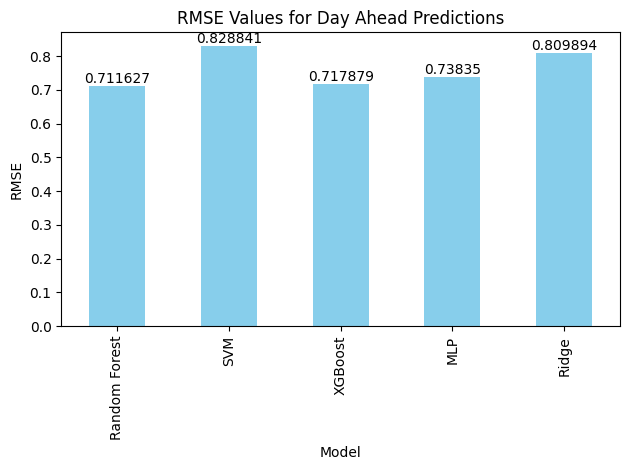

,RMSE
Random Forest,0.711627
SVM,0.828841
XGBoost,0.717879
MLP,0.738350
Ridge,0.809894


In [56]:
# create a dataframe with the RMSE values for day ahead and plot in bar chart
mbe_values_day = [rf_mbe_day, svm_mbe_day, xgb_mbe_day, mlp_mbe_day, ridge_mbe_day]
rmse_values_day = [rf_rmse_day, svm_rmse_day, xgb_rmse_day, mlp_rmse_day, ridge_rmse_day]
models = ['Random Forest', 'SVM', 'XGBoost', 'MLP', 'Ridge']
mbe_df_day = pd.DataFrame(mbe_values_day, index=models, columns=['MBE'])
rmse_df_day = pd.DataFrame(rmse_values_day, index=models, columns=['RMSE'])
ax = rmse_df_day.plot(kind='bar', color='skyblue', legend=False)
plt.title('RMSE Values for Day Ahead Predictions')
plt.ylabel('RMSE')
plt.xlabel('Model')
for container in ax.containers:
    ax.bar_label(container)
plt.tight_layout()
plt.show()
rmse_df_day

In [57]:
y_test_day_df = pd.DataFrame(y_test_day)
y_test_day_groups = y_test_day_df.groupby(y_test_day_df.index.date)
rmse_per_day = []
y_test_day_df['prediction']  = predictions_rf_day
y_test_day_df

,var1(t),prediction
Timestamp,,
2023-07-09 12:00:00,5.4000,5.446393
2023-07-09 12:15:00,5.5100,6.096504
2023-07-09 12:30:00,5.4750,5.578374
2023-07-09 12:45:00,5.4825,5.309786
2023-07-09 13:00:00,5.2400,5.607866
...,...,...
2023-12-31 22:45:00,5.3775,5.600711
2023-12-31 23:00:00,5.2825,5.745172
2023-12-31 23:15:00,5.3900,5.668510


In [58]:
grouped = y_test_day_df.groupby(y_test_day_df.index.date)

# Calculate RMSE for each group
rmse_results = {}
for date, group in grouped:
    rmse = sqrt(mean_squared_error(group['var1(t)'], group['prediction']))
    rmse_results[date] = rmse

# Print RMSE results
for date, rmse in rmse_results.items():
    if rmse > 1:
        print(f"RMSE for {date}: {rmse}")

RMSE for 2023-08-07: 1.48175344136076
RMSE for 2023-08-28: 1.1926225056349422
RMSE for 2023-08-29: 1.270322200525241
RMSE for 2023-08-30: 1.2874543685872246
RMSE for 2023-08-31: 1.098997378405466
RMSE for 2023-09-04: 1.069451196828586
RMSE for 2023-09-11: 1.1167973962517488
RMSE for 2023-10-16: 1.0002308022258433
RMSE for 2023-10-30: 3.786795671397702
RMSE for 2023-10-31: 1.1535815651614088
RMSE for 2023-11-06: 1.2991324744768453
RMSE for 2023-11-13: 1.3623221693584693
RMSE for 2023-11-20: 1.1009051014255269
RMSE for 2023-12-03: 1.4611468912501961
RMSE for 2023-12-04: 1.4056270774790705
RMSE for 2023-12-11: 1.220545023010079
RMSE for 2023-12-25: 1.837307441269906
RMSE for 2023-12-26: 1.2395591544346671


In [59]:
transformed_df_step= series_to_supervised(df2023, n_in=[1,2,3,4,96,672],n_out=1)
columns_to_keep = [col for col in transformed_df_step.columns if 'var1(t-' in col] + ['var2(t)', 'var3(t)']
X_step= transformed_df_step[columns_to_keep]
y_step = transformed_df_step['var1(t)']
X_train_step, X_test_step, y_train_step, y_test_step = train_test_split(X_step, y_step, test_size=0.5, shuffle=False)
X_train_scaled_step = scaler.fit_transform(X_train_step)
X_test_scaled_step = scaler.transform(X_test_step)

In [60]:
param_dist = {
    'n_estimators': [100, 200],
    'max_depth': [10, 15],
    'min_samples_split': [5, 10],
    'min_samples_leaf': [1, 2, 4]
}
model = RandomForestRegressor()
tscv = TimeSeriesSplit(n_splits=5)

random_search = RandomizedSearchCV(estimator=model, param_distributions=param_dist, cv=tscv, scoring='neg_mean_squared_error', n_jobs=-1,verbose=3,random_state=1)

random_search.fit(X_train_scaled_step, y_train_step)
results = random_search.cv_results_

for i in range(len(results['params'])):
    params = results['params'][i]
    mean_test_score = results['mean_test_score'][i]
    rmse = np.sqrt(-mean_test_score)
    print(f"Iteration {i+1}: Params: {params}, RMSE: {rmse}")

best_rf_step = random_search.best_estimator_
print(f"Best parameters: {best_rf_step}")

best_score = np.sqrt(-random_search.best_score_)
print(f"Best RMSE: {best_score}")

predictions_rf_step = best_rf_step.predict(X_test_scaled_step)
rf_rmse_step = sqrt(mean_squared_error(y_test_step, predictions_rf_step))
print(f"Best RMSE on Test Set: {rf_rmse_step}")

rf_mbe_step = mean_bias_error(y_test_step, predictions_rf_step)
print(f"Mean Bias Error on Test Set: {rf_mbe_step}")

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Iteration 1: Params: {'n_estimators': 200, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_depth': 15}, RMSE: 0.2861633264236497
Iteration 2: Params: {'n_estimators': 100, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_depth': 15}, RMSE: 0.2860421556901036
Iteration 3: Params: {'n_estimators': 200, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_depth': 10}, RMSE: 0.28344899082723696
Iteration 4: Params: {'n_estimators': 100, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_depth': 15}, RMSE: 0.2856250568626184
Iteration 5: Params: {'n_estimators': 100, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_depth': 15}, RMSE: 0.2844723260074316
Iteration 6: Params: {'n_estimators': 200, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_depth': 15}, RMSE: 0.28557628346460073
Iteration 7: Params: {'n_estimators': 100, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_depth': 10}, RMSE: 0.2829209834407625
It

In [61]:
svm_model = make_pipeline(StandardScaler(), SVR(kernel='linear'))

# Time series cross-validator
tscv = TimeSeriesSplit(n_splits=5)

# Parameter grid
param_grid = {
    'svr__C': [0.1, 1, 10],
    'svr__epsilon': [0.01, 0.1, 1]
}

# Instantiate GridSearchCV with verbose=3 for detailed output
grid_search = GridSearchCV(svm_model, param_grid, cv=tscv, scoring='neg_mean_squared_error', n_jobs=-1, verbose=3)

# Fit GridSearchCV
grid_search.fit(X_train_scaled_step, y_train_step)
results = grid_search.cv_results_
for i in range(len(results['params'])):
    params = results['params'][i]
    mean_test_score = results['mean_test_score'][i]
    rmse = np.sqrt(-mean_test_score)
    print(f"Iteration {i+1}: Params: {params}, RMSE: {rmse}")
# Best parameters
best_svm_step = grid_search.best_estimator_
print(f"Best parameters: {best_svm_step}")

best_score = np.sqrt(-grid_search.best_score_)
print(f"Best RMSE: {best_score}")

predictions_svm_step = best_svm_step.predict(X_test_scaled_step)
svm_rmse_step = sqrt(mean_squared_error(y_test_step, predictions_svm_step))
print(f"Best RMSE on Test Set: {svm_rmse_step}")

svm_mbe_step = mean_bias_error(y_test_step, predictions_svm_step)
print(f"Mean Bias Error on Test Set: {svm_mbe_step}")

Fitting 5 folds for each of 9 candidates, totalling 45 fits
Iteration 1: Params: {'svr__C': 0.1, 'svr__epsilon': 0.01}, RMSE: 0.2799261211847241
Iteration 2: Params: {'svr__C': 0.1, 'svr__epsilon': 0.1}, RMSE: 0.27929271641237763
Iteration 3: Params: {'svr__C': 0.1, 'svr__epsilon': 1}, RMSE: 0.3718790361052196
Iteration 4: Params: {'svr__C': 1, 'svr__epsilon': 0.01}, RMSE: 0.27844197124064357
Iteration 5: Params: {'svr__C': 1, 'svr__epsilon': 0.1}, RMSE: 0.27758841980237803
Iteration 6: Params: {'svr__C': 1, 'svr__epsilon': 1}, RMSE: 0.35315696973597716
Iteration 7: Params: {'svr__C': 10, 'svr__epsilon': 0.01}, RMSE: 0.27834380290523997
Iteration 8: Params: {'svr__C': 10, 'svr__epsilon': 0.1}, RMSE: 0.27743515652353146
Iteration 9: Params: {'svr__C': 10, 'svr__epsilon': 1}, RMSE: 0.3473292773140892
Best parameters: Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svr', SVR(C=10, kernel='linear'))])
Best RMSE: 0.27743515652353146
Best RMSE on Test Set: 0.294198125

In [62]:
# parameters for the MLP model
param_dist = {
    'n_estimators': [50, 100, 150],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 0.9, 1],
    'colsample_bytree': [0.8, 0.9, 1],
}

# time series cross-validator
tscv = TimeSeriesSplit(n_splits=5)

xgb_model = XGBRegressor(objective='reg:squarederror')

# random search
random_search = RandomizedSearchCV(estimator=xgb_model, param_distributions=param_dist, n_iter=10, cv=tscv, scoring='neg_mean_squared_error', n_jobs=-1, verbose=2, random_state=1)
random_search.fit(X_train_scaled_step, y_train_step)
results = random_search.cv_results_

print("All iterations:")
for i in range(len(results['params'])):
    params = results['params'][i] 
    mean_test_score = results['mean_test_score'][i]  
    rmse = np.sqrt(-mean_test_score) 
    print(f"Iteration {i+1}: Params: {params}, RMSE: {rmse}")

best_XGB_step = random_search.best_estimator_
print("Best parameters found: ", best_XGB_step)

best_score = np.sqrt(-random_search.best_score_)
print(f"Best RMSE: {best_score}")

predictions_xgb_step = best_XGB_step.predict(X_test_scaled_step)
xgb_rmse_step = sqrt(mean_squared_error(y_test_step, predictions_xgb_step))
print(f"Test RMSE with XGBoost using optimized parameters: {xgb_rmse_step}")

xgb_mbe_step = mean_bias_error(y_test_step, predictions_xgb_step)
print(f"Mean Bias Error on Test Set: {xgb_mbe_step}")


Fitting 5 folds for each of 10 candidates, totalling 50 fits
All iterations:
Iteration 1: Params: {'subsample': 0.9, 'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.1, 'colsample_bytree': 0.8}, RMSE: 0.28271805191654514
Iteration 2: Params: {'subsample': 1, 'n_estimators': 150, 'max_depth': 7, 'learning_rate': 0.1, 'colsample_bytree': 1}, RMSE: 0.29040879934418895
Iteration 3: Params: {'subsample': 0.9, 'n_estimators': 150, 'max_depth': 5, 'learning_rate': 0.05, 'colsample_bytree': 1}, RMSE: 0.2763968692733241
Iteration 4: Params: {'subsample': 1, 'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.05, 'colsample_bytree': 0.9}, RMSE: 0.2753760267452692
Iteration 5: Params: {'subsample': 1, 'n_estimators': 150, 'max_depth': 3, 'learning_rate': 0.01, 'colsample_bytree': 0.9}, RMSE: 0.5985466357935759
Iteration 6: Params: {'subsample': 0.9, 'n_estimators': 50, 'max_depth': 3, 'learning_rate': 0.1, 'colsample_bytree': 1}, RMSE: 0.2757737750718089
Iteration 7: Params: {'subsampl

In [63]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('mlp', MLPRegressor(max_iter=1000))
])

# paramater grid
param_distributions = {
    'mlp__hidden_layer_sizes': [(50,), (100,)],
    'mlp__activation': ['tanh', 'relu'],
    'mlp__alpha': np.logspace(-4, -2, 3) 
}

# set up the randomized search
random_search = RandomizedSearchCV(pipeline, param_distributions, n_iter=5, 
                                   scoring='neg_mean_squared_error', cv=3, verbose=2, random_state=1)

random_search.fit(X_train_step, y_train_step)
results = random_search.cv_results_

print("All iterations:")
for i in range(len(results['params'])):
    params = results['params'][i] 
    mean_test_score = results['mean_test_score'][i]  
    rmse = np.sqrt(-mean_test_score) 
    print(f"Iteration {i+1}: Params: {params}, RMSE: {rmse}")
    
best_mlp_step = random_search.best_estimator_
print("Best parameters:", best_mlp_step)
best_score = np.sqrt(-random_search.best_score_)
print(f"Best RMSE: {best_score}")
predictions_mlp_step = best_mlp_step.predict(X_test_step)
mlp_rmse_step = sqrt(mean_squared_error(y_test_step, predictions_mlp_step))
print(f"Test RMSE with optimized MLP: {mlp_rmse_step}")

mlp_mbe_step = mean_bias_error(y_test_step, predictions_mlp_step)
print(f"Mean Bias Error on Test Set: {mlp_mbe_step}")

Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV] END mlp__activation=tanh, mlp__alpha=0.001, mlp__hidden_layer_sizes=(50,); total time=   1.7s
[CV] END mlp__activation=tanh, mlp__alpha=0.001, mlp__hidden_layer_sizes=(50,); total time=   2.7s
[CV] END mlp__activation=tanh, mlp__alpha=0.001, mlp__hidden_layer_sizes=(50,); total time=   2.3s
[CV] END mlp__activation=tanh, mlp__alpha=0.001, mlp__hidden_layer_sizes=(100,); total time=   2.9s
[CV] END mlp__activation=tanh, mlp__alpha=0.001, mlp__hidden_layer_sizes=(100,); total time=   2.1s
[CV] END mlp__activation=tanh, mlp__alpha=0.001, mlp__hidden_layer_sizes=(100,); total time=   3.2s
[CV] END mlp__activation=tanh, mlp__alpha=0.01, mlp__hidden_layer_sizes=(50,); total time=   2.5s
[CV] END mlp__activation=tanh, mlp__alpha=0.01, mlp__hidden_layer_sizes=(50,); total time=   2.5s
[CV] END mlp__activation=tanh, mlp__alpha=0.01, mlp__hidden_layer_sizes=(50,); total time=   2.7s
[CV] END mlp__activation=relu, mlp__alpha=0.01, m

In [64]:
# Define a pipeline that standardizes the data then applies Ridge regression
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('ridge', Ridge())
])

param_grid = {
    'ridge__alpha': np.logspace(-4, 4, 10)
}

tscv = TimeSeriesSplit(n_splits=5)

random_search = RandomizedSearchCV(pipeline, param_grid, cv=tscv, scoring='neg_mean_squared_error', n_jobs=-1, verbose=2)
random_search.fit(X_train_step, y_train_step)

results = random_search.cv_results_
print("All iterations:")
for i in range(len(results['params'])):
    params = results['params'][i]
    mean_test_score = results['mean_test_score'][i]
    rmse = np.sqrt(-mean_test_score)
    print(f"Iteration {i+1}: Params: {params}, RMSE: {rmse}")

best_mlr_step = random_search.best_estimator_
print("Best parameters:", best_mlr_step)
best_score = np.sqrt(-random_search.best_score_)
print(f"Best RMSE: {best_score}")
predictions_ridge_step = best_mlr_step.predict(X_test_step)
ridge_rmse_step = sqrt(mean_squared_error(y_test_step, predictions_ridge_step))  
print(f"Test RMSE with optimized Ridge regression: {ridge_rmse_step}")


ridge_mbe_step = mean_bias_error(y_test_step, predictions_ridge_step)
print(f"Mean Bias Error on Test Set: {ridge_mbe_step}")

Fitting 5 folds for each of 10 candidates, totalling 50 fits
All iterations:
Iteration 1: Params: {'ridge__alpha': 0.0001}, RMSE: 0.27779547870198884
Iteration 2: Params: {'ridge__alpha': 0.000774263682681127}, RMSE: 0.2777954481850072
Iteration 3: Params: {'ridge__alpha': 0.005994842503189409}, RMSE: 0.27779521390288103
Iteration 4: Params: {'ridge__alpha': 0.046415888336127774}, RMSE: 0.27779351909920147
Iteration 5: Params: {'ridge__alpha': 0.3593813663804626}, RMSE: 0.277787218704167
Iteration 6: Params: {'ridge__alpha': 2.782559402207126}, RMSE: 0.2780387157278565
Iteration 7: Params: {'ridge__alpha': 21.54434690031882}, RMSE: 0.2848564637728651
Iteration 8: Params: {'ridge__alpha': 166.81005372000558}, RMSE: 0.33630505295101937
Iteration 9: Params: {'ridge__alpha': 1291.5496650148827}, RMSE: 0.43842148124585234
Iteration 10: Params: {'ridge__alpha': 10000.0}, RMSE: 0.7733984717203305
Best parameters: Pipeline(steps=[('scaler', StandardScaler()),
                ('ridge', Ridge(al

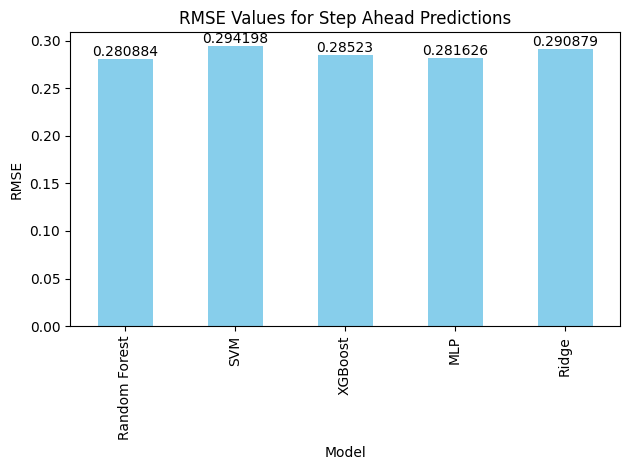

,RMSE
Random Forest,0.280884
SVM,0.294198
XGBoost,0.285230
MLP,0.281626
Ridge,0.290879


In [65]:
# create a dataframe with the RMSE values for step ahead and plot in bar chart
mbe_values_step = [rf_mbe_step, svm_mbe_step, xgb_mbe_step, mlp_mbe_step, ridge_mbe_step]
rmse_values_step = [rf_rmse_step, svm_rmse_step, xgb_rmse_step, mlp_rmse_step, ridge_rmse_step]
models = ['Random Forest', 'SVM', 'XGBoost', 'MLP', 'Ridge']
mbe_df_step = pd.DataFrame(mbe_values_step, index=models, columns=['MBE'])
rmse_df_step = pd.DataFrame(rmse_values_step, index=models, columns=['RMSE'])
ax = rmse_df_step.plot(kind='bar', color='skyblue', legend=False)
plt.title('RMSE Values for Step Ahead Predictions')
plt.ylabel('RMSE')
plt.xlabel('Model')
for container in ax.containers:
    ax.bar_label(container)
plt.tight_layout()
plt.show()
rmse_df_step

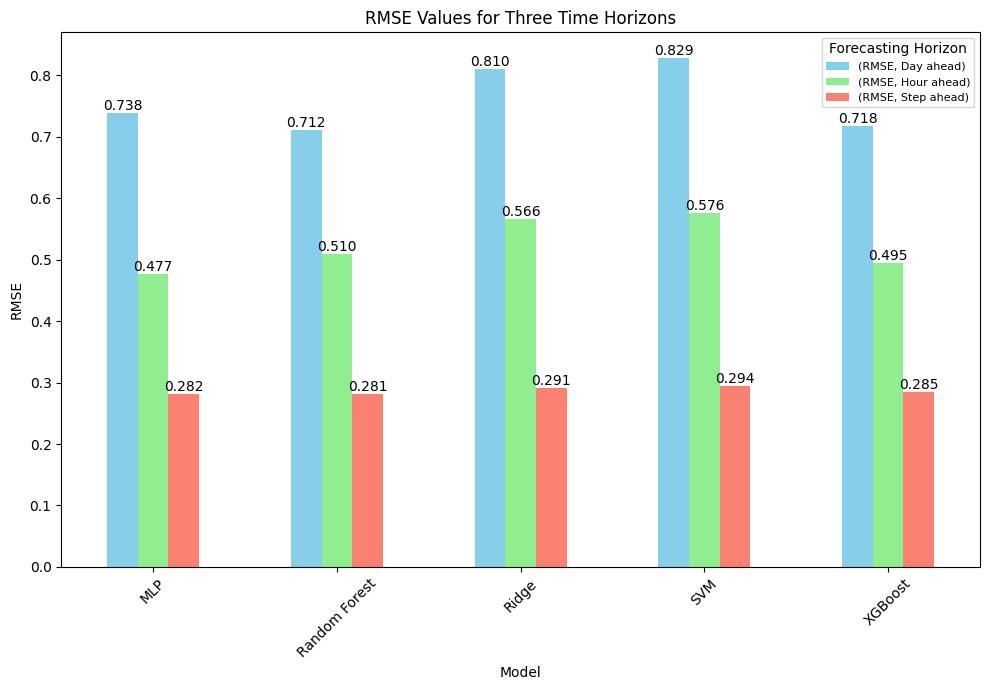

In [66]:
# create a dataframe with the RMSE values for three time horizons and plot in bar chart with model labels in different colors

horizons = ['Hour ahead', 'Day ahead', 'Step ahead']
rmse_values = [
    # Random Forest
    rf_rmse_hour, rf_rmse_day, rf_rmse_step, 
    # SVM
    svm_rmse_hour, svm_rmse_day, svm_rmse_step, 
    # XGBoost
    xgb_rmse_hour, xgb_rmse_day, xgb_rmse_step, 
    # MLP
    mlp_rmse_hour, mlp_rmse_day, mlp_rmse_step, 
    # Ridge
    ridge_rmse_hour, ridge_rmse_day, ridge_rmse_step
]

# Setting up multi-indexing for models and horizons
index = pd.MultiIndex.from_product([models, horizons], names=['Model', 'Horizon'])

# Creating the DataFrame
rmse_df = pd.DataFrame(rmse_values, index=index, columns=['RMSE'])

# Plotting
# Unstack the 'Horizon' level of the index to create grouped bars
ax = rmse_df.unstack(level='Horizon').plot(kind='bar', color=['skyblue', 'lightgreen', 'salmon'], legend=True, figsize=(10, 7))
ax.set_title('RMSE Values for Three Time Horizons')
ax.set_ylabel('RMSE')
ax.set_xlabel('Model')

# Adding bar labels
for container in ax.containers:
    ax.bar_label(container, fmt='%.3f')  # Formatting to 2 decimal places

plt.xticks(rotation=45)  # Rotate model names for better readability
plt.legend(title='Forecasting Horizon',fontsize=8)
plt.tight_layout()
plt.show()

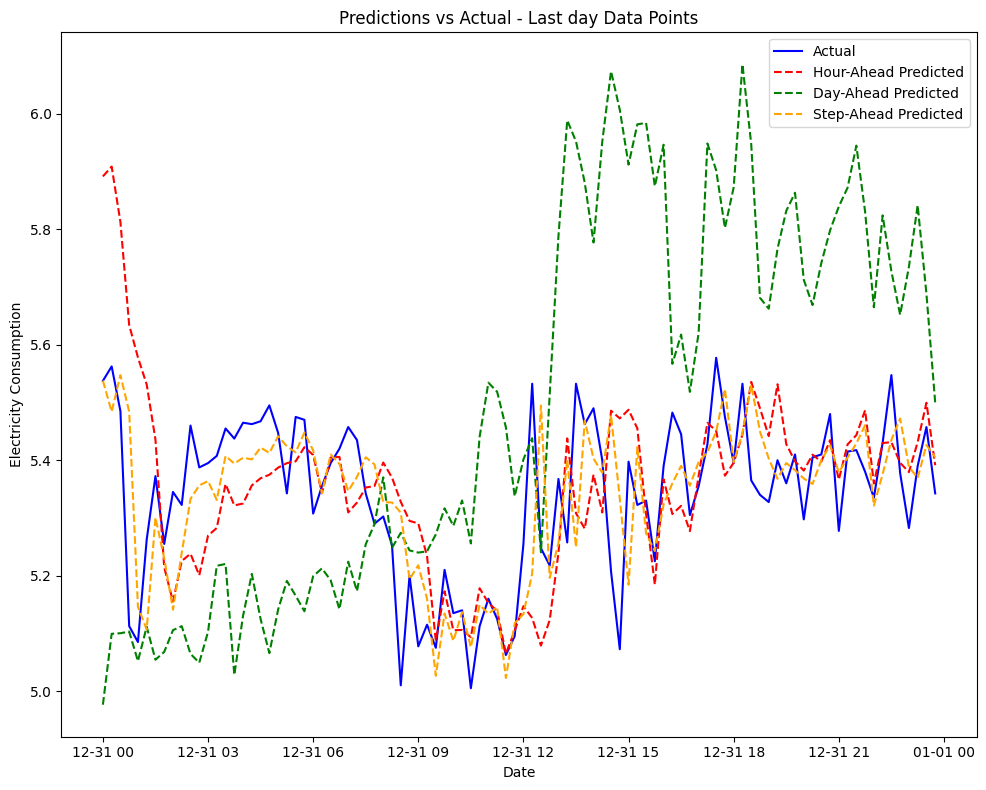

In [67]:
plt.figure(figsize=(10, 8))
plt.plot(y_test_hour.index[-96:], y_test_hour[-96:], label='Actual', color='blue')

# Plotting the predicted values for each forecast type
plt.plot(y_test_hour.index[-96:], predictions_mlp_hour[-96:], label='Hour-Ahead Predicted', color='red', linestyle='--')
plt.plot(y_test_day.index[-96:], predictions_mlp_day[-96:], label='Day-Ahead Predicted', color='green', linestyle='--')
plt.plot(y_test_step.index[-96:], predictions_rf_step[-96:], label='Step-Ahead Predicted', color='orange', linestyle='--')


plt.title('Predictions vs Actual - Last day Data Points')
plt.xlabel('Date')
plt.ylabel('Electricity Consumption')


plt.legend()
plt.tight_layout()

# Display the plot
plt.show()

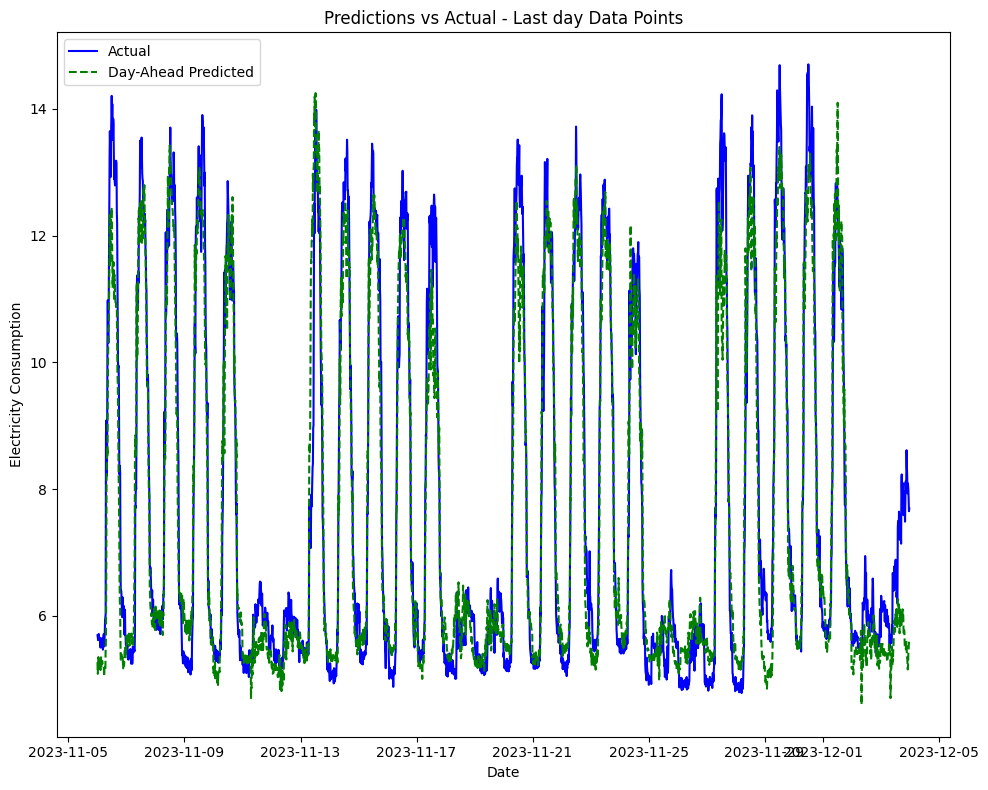

In [68]:
plt.figure(figsize=(10, 8))
plt.plot(y_test_hour.index[-5376:-2688], y_test_hour[-5376:-2688], label='Actual', color='blue')

# Plotting the predicted values for each forecast type
# plt.plot(y_test_hour.index[-5376:-2688], predictions_mlp_hour[-5376:-2688], label='Hour-Ahead Predicted', color='red', linestyle='--')
plt.plot(y_test_day.index[-5376:-2688], predictions_mlp_day[-5376:-2688], label='Day-Ahead Predicted', color='green', linestyle='--')
# plt.plot(y_test_step.index[-5376:-2688], predictions_rf_step[-5376:-2688], label='Step-Ahead Predicted', color='orange', linestyle='--')


plt.title('Predictions vs Actual - Last day Data Points')
plt.xlabel('Date')
plt.ylabel('Electricity Consumption')


plt.legend()
plt.tight_layout()

# Display the plot
plt.show()

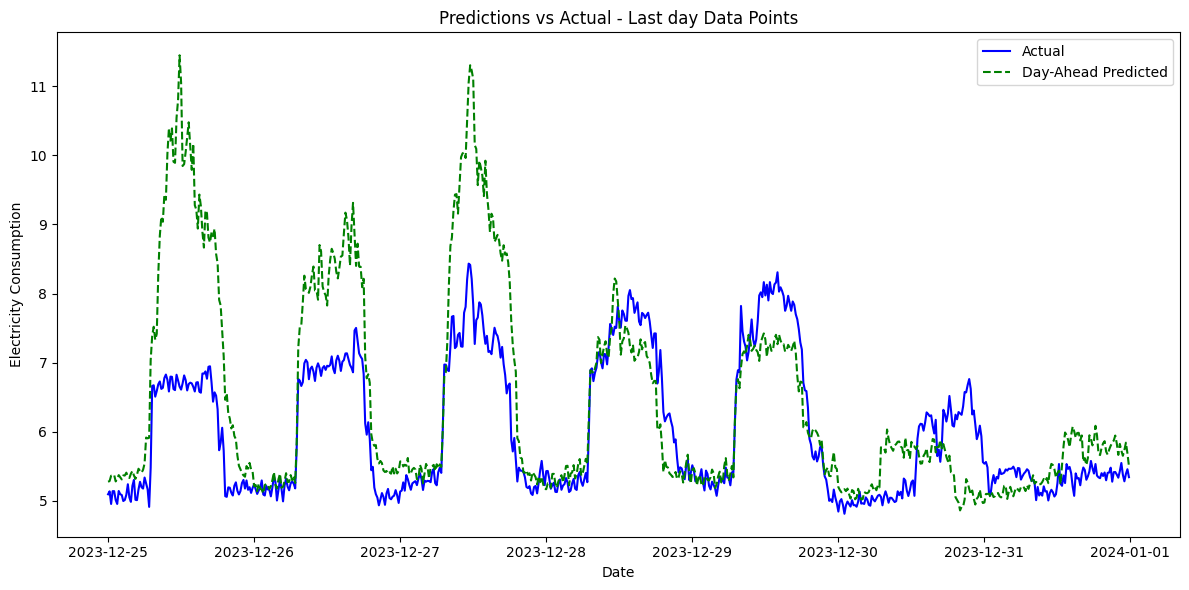

In [70]:
plt.figure(figsize=(12, 6))
plt.plot(y_test_hour.index[-672:], y_test_hour[-672:], label='Actual', color='blue')

# Plotting the predicted values for each forecast type
# plt.plot(y_test_hour.index[-96:], predictions_mlp_hour[-96:], label='Hour-Ahead Predicted', color='red', linestyle='--')
plt.plot(y_test_day.index[-672:], predictions_mlp_day[-672:], label='Day-Ahead Predicted', color='green', linestyle='--')
# plt.plot(y_test_step.index[-96:], predictions_rf_step[-96:], label='Step-Ahead Predicted', color='orange', linestyle='--')


plt.title('Predictions vs Actual - Last day Data Points')
plt.xlabel('Date')
plt.ylabel('Electricity Consumption')


plt.legend()
plt.tight_layout()

# Display the plot
plt.show()